# **This is your final assignment.**  

You'll get a lot of freedom in doing this assignment but that also means you have to make choices and explain the reasoning behind those choices in your report.

For this assignment you can use any dataset you can find from the https://ourworldindata.org/ website.(opens in a new tab)

Please formulate an answer to the following three questions in your report.

1. What is the biggest predictor of a large CO2 output per capita of a country?
2. which countries are making the biggest strides in decreasing CO2 output?
3. which non-fossil fuel energy technology will have the best price in the future?


In [2]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

### **1: Biggest predictor of CO2 output**
#### What is the biggest predictor of a large CO2 output per capita of a country?

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors.

#### Choices made:
* Looking at the period after the end of the cold war (1991) untill 2019 when Covid-19 hit. After the cold war,  the world entered an era of relative stability   
and peace marked with a lot of economic growth.  And before the Covid-19 hits because the pandemic brought of a lot of changes to peoples lifestyle and consequence  
to economic activity.
* I choose energy, gdp and meat production as my factors to answer this question.

#### **Sources** 
CO2 emmissions = Per capita CO2 emissions, 
https://ourworldindata.org/explorers/co2?facet=none&country=CHN~USA~IND~GBR~OWID_WRL&Gas=CO%E2%82%82&Accounting=Production-based&Fuel+or+Land+Use+Change=All+fossil+emissions&Count=Per+capita 

GDP = Real GDP per Capita 2019, https://ourworldindata.org/grapher/real-gdp-per-capita-PennWT 

Meat production = Per capita meat consumption by type, https://ourworldindata.org/grapher/per-capita-meat-consumption-by-type-kilograms-per-year 

Energy = "Primary energy consumption per capita, measured in kilowatt-hours per person per year.", https://ourworldindata.org/explorers/energy?facet=none&country=USA~GBR~CHN~OWID_WRL~IND~BRA~ZAF&hideControls=false&Total+or+Breakdown=Total&Energy+or+Electricity=Primary+energy&Metric=Per+capita+consumption 

In [3]:
world_co2 = pd.read_csv('co2.csv')
GDP_capita = pd.read_csv("real-gdp-per-capita-PennWT.csv")
meat_prod = pd.read_csv("per-capita-meat-consumption-by-type-kilograms-per-year.csv")
energy = pd.read_csv('energy.csv')


#renaming columns
energy.rename(columns={'Primary energy consumption per capita (kWh/person)': 'Energy use'}, inplace=True)
world_co2.rename(columns={'Annual CO₂ emissions (per capita)': 'CO2'}, inplace=True)
GDP_capita.rename(columns={'GDP per capita (output, multiple price benchmarks)': 'GDP'} , inplace=True)
meat_prod.rename(columns={meat_prod.columns[-5]:'Other',meat_prod.columns[-4]:'Sheep & Goat', meat_prod.columns[-3]: 'Beef',   meat_prod.columns[-2]: 'Pork', meat_prod.columns[-1]: 'Poultry' }, inplace=True)


In [4]:
#Preparing meat dataset
#filling in na for pork with 0 -> NA values only for muslim countries
meat_prod.fillna({'Pork': 0}, inplace=True)

#summing up all meat per country year
target_columns = ['Other', 'Sheep & Goat', 'Beef', 'Pork', 'Poultry']
meat_prod['Meat consumption'] = meat_prod.loc[:, target_columns].sum(axis=1)
meat_prod.drop(columns=target_columns, inplace=True)


In [5]:
data_sets = [world_co2, GDP_capita, meat_prod, energy]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Entity', 'Code', 'Year'], how='outer'), data_sets)
df_merged = df_merged.loc[(df_merged['Year'] >= 1992) & (df_merged['Year'] <= 2019)]
df_merged.dropna(subset=['CO2','GDP', 'Meat consumption', 'Energy use'], inplace=True)

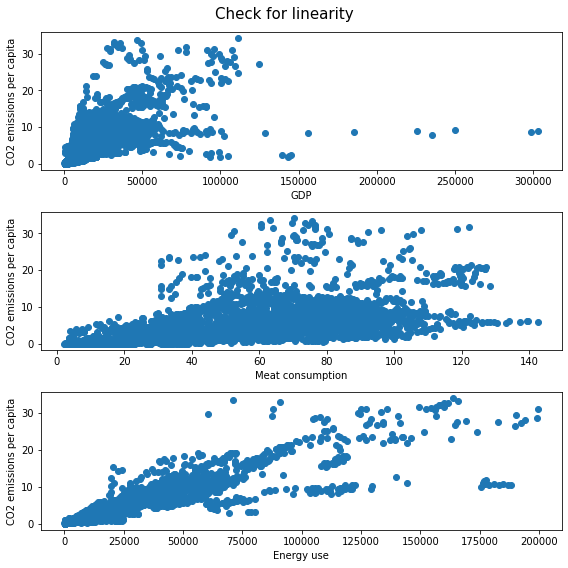

In [6]:
X = df_merged[['GDP', 'Meat consumption', 'Energy use']].copy()
y = df_merged['CO2'].copy()

#Testing for linearity vs CO2
fig1, axs = plt.subplots(3,1, figsize=(8,8), sharey=True)

#subplot 1
fig1.suptitle('Check for linearity', fontsize=15)
axs[0].scatter(X['GDP'], y)
axs[0].set_ylabel('CO2 emissions per capita')
axs[0].set_xlabel('GDP')

#subplot 2
axs[1].scatter(X['Meat consumption'], y)
axs[1].set_ylabel('CO2 emissions per capita')
axs[1].set_xlabel('Meat consumption')

#subplot 3
axs[2].scatter(X['Energy use'], y)
axs[2].set_ylabel('CO2 emissions per capita')
axs[2].set_xlabel('Energy use')
plt.tight_layout()
plt.show()


#seems to be linear but with a lot of outliers.

In [7]:
#Multiple regression model
X2 = sm.add_constant(X)
results = sm.OLS(y, X2).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     6341.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):               0.00
Time:                        18:28:06   Log-Likelihood:                -10292.
No. Observations:                4551   AIC:                         2.059e+04
Df Residuals:                    4547   BIC:                         2.062e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0803      0.063  

In [8]:
output = [results.params, results.bse, results.tvalues, results.pvalues, results.conf_int()]
output = pd.concat(output, axis=1).round(4)
output.columns = ['Value', 'Standard Error', 't-Statistic', 'p-Value', 'Lower CI', 'Upper CI']

print(output)

                   Value  Standard Error  t-Statistic  p-Value  Lower CI  \
const             0.0803          0.0628       1.2774   0.2015   -0.0429   
GDP               0.0000          0.0000       1.9452   0.0518   -0.0000   
Meat consumption  0.0177          0.0015      11.4593   0.0000    0.0147   
Energy use        0.0001          0.0000      83.0794   0.0000    0.0001   

                  Upper CI  
const               0.2035  
GDP                 0.0000  
Meat consumption    0.0207  
Energy use          0.0002  


In [9]:
#because of multicollinearity 
from scipy.stats import pearsonr
target = df_merged[['CO2', 'GDP', 'Meat consumption', 'Energy use']].copy()
rho = target.corr()
pval =target.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(target.columns))
p= pval.applymap(lambda x: ''.join(['*' for t in [0.05, 0.01, 0.001] if x <= t]))
display(rho.round(2).astype(str) + p)
print('P-values: * = 0.05, ** = 0.01, *** = 0.001')

,CO2,GDP,Meat consumption,Energy use
CO2,1.0***,0.68***,0.62***,0.89***
GDP,0.68***,1.0***,0.65***,0.72***
Meat consumption,0.62***,0.65***,1.0***,0.62***
Energy use,0.89***,0.72***,0.62***,1.0***


P-values: * = 0.05, ** = 0.01, *** = 0.001


#### Conclusion: 
The biggest predictor of CO2 emissions is energy use followed by GDP and last is meat consumption. All values are significant what indication a statistically significant association.

### **2: Biggest strides in decreasing CO2 output**

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably  
a good idea to take this into account as well.  

2. which countries are making the biggest strides in decreasing CO2 output?

#### Choices:  

Chosen time period starts from 1997 untill 2019. The kyoto protocol was the result of the second climate conference in Geneve, where signatory countries commits to reducing   
global warming. It was signed on 11 december 1997 in Kyoto, Japan. Since it was late in the year I have chosen 1998 as the starting point. I picked 2019 as end point because  
2020 was dominated by the pandemic which had a detrimental effect on people's way of life and economic activity.    

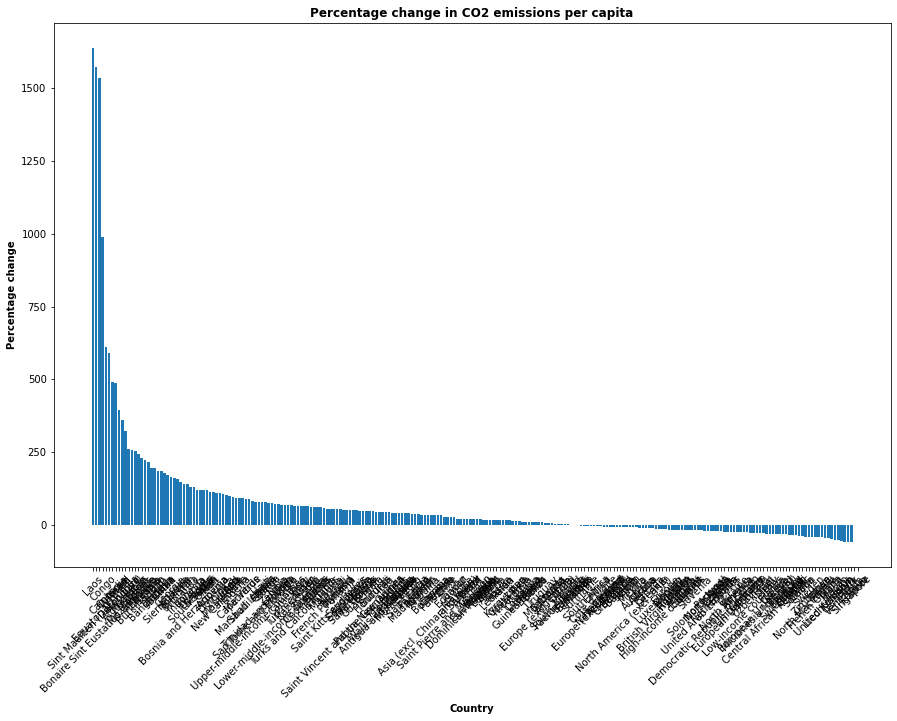

In [10]:
CO2_2019 = world_co2.loc[(world_co2['Year'] >= 1998) & (world_co2['Year'] <= 2019)].copy()
change_co2 = CO2_2019.pivot(index=['Entity'], columns=['Year'], values='CO2')

#selecting columns and calculate percentage change
target_change = change_co2.iloc[:, [0, -1]].copy()
target_change['Percent Change'] = (target_change.pct_change(axis=1)[target_change.columns[1]]) * 100
target_change.sort_values(by=['Percent Change'], inplace=True, ascending = False)

#Plotting bar chart -> all data = unreadable barchart
fig2 = plt.figure(figsize=(15,10))
plt.bar(target_change.index, target_change['Percent Change'])
plt.xlabel('Country', weight='bold')
plt.ylabel('Percentage change', weight='bold')
plt.title('Percentage change in CO2 emissions per capita', weight='bold')
plt.xticks(rotation=45)
plt.show()

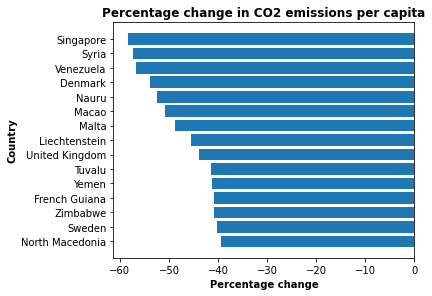

In [11]:
#displaying 15 countries with the biggest co2 reduction
Country_reduction = target_change.dropna().tail(15)
plt.barh(Country_reduction.index, Country_reduction['Percent Change'])
plt.ylabel('Country', weight='bold')
plt.xlabel('Percentage change', weight='bold')
plt.tight_layout()
plt.title('Percentage change in CO2 emissions per capita', weight='bold')
plt.show()


#### which countries are making the biggest strides in decreasing CO2 output?  
Singapore is the country with the highest reduction in CO2 emissions followed by Syria, Venezuela and Denmark.


### **3: Best future price for non-fossil fuel energy**

To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.  
3. which non-fossil fuel energy technology will have the best price in the future?

### Choices:
* The cost of energy production would be used instead of the price that end-users pay for energy. The is no data on cost of energy per household across the world.   
For example, electricity is sold on a wholesale market where the most expensive power plant determines the end price. Since cost does effect the price, a data  
set on the cost of production for renewable energy is used.
* I only concentrated on world (OWID_WRL) since the question doesnt involve any country and the dataset contains limited country information

### Sources

Cost of energy production: https://ourworldindata.org/grapher/levelized-cost-of-energy

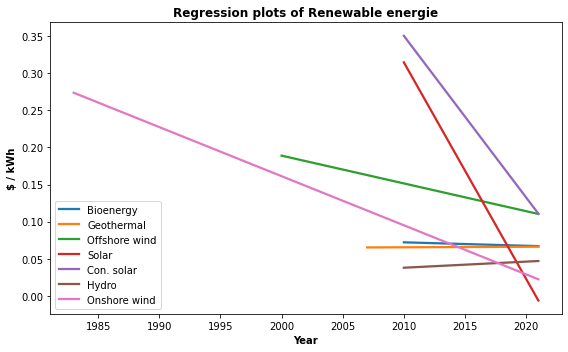

In [14]:
import seaborn as sns

energy_cost = pd.read_csv("levelized-cost-of-energy.csv")

# filtering out countries
world_cost = energy_cost.loc[energy_cost['Entity'] == 'World'].copy()
world_cost.drop(columns=['Entity', 'Code'], inplace=True)
world_cost.rename(columns={'Bioenergy levelized cost of energy': 'Bioenergy', 'Geothermal levelized cost of energy': 'Geothermal',
'Offshore wind levelized cost of energy': 'Offshore wind', 'Solar photovoltaic levelized cost of energy' : 'Solar',
'Concentrated solar power levelized cost of energy': 'Con. solar', 'Hydropower levelized cost of energy': 'Hydro',
'Onshore wind levelized cost of energy': 'Onshore wind'}, inplace=True)

#matplotlib madlibs
fig3, ax3 = plt.subplots(figsize=(8,5))

for columnNames in world_cost.columns[1::]:
    sns.regplot(x='Year', y=columnNames, data= world_cost, fit_reg=True, ci=False, scatter=False, ax=ax3, label=columnNames)

ax3.legend()
ax3.set_xlabel(xlabel='Year', weight='bold')
ax3.set_ylabel(ylabel='$ / kWh', weight='bold')
ax3.set_title('Regression plots of Renewable energie', weight = 'bold')
plt.tight_layout()
plt.show()

#From look at the lines "Solar photovoltaic levelized cost of energy / Solar" would most likely have the lowest price in the future.

In [15]:
#Testing for relationship 
for columnNames in world_cost.columns[1::]:
    model = smf.ols(f'Year ~ Q("{columnNames}")', data=world_cost)
    results = model.fit()
    aov = sm.stats.anova_lm(results, typ=2)
    p = aov.loc[f'Q("{columnNames}")', 'PR(>F)']
    print(f'Q("{columnNames}")', f'p-value = {p}')

#Bioenergy and Geothermal cant reject to H0 hypothesis. In other words the cost of these energy source would probably remain the same.


Q("Bioenergy") p-value = 0.5621514932999724
Q("Geothermal") p-value = 0.9325924408618381
Q("Offshore wind") p-value = 0.004079724767301661
Q("Solar") p-value = 3.0510684030862373e-05
Q("Con. solar") p-value = 1.2253456606123135e-05
Q("Hydro") p-value = 0.03519027383513799
Q("Onshore wind") p-value = 1.258519630750604e-23


In [28]:
for columnNames in world_cost.columns[1::]:
    test = world_cost.dropna(subset=[columnNames])
    X_year = sm.add_constant(test['Year'])
    model = sm.OLS(test[columnNames],X_year).fit()
    predictions = model.predict(sm.add_constant([2020, 2021, 2022, 2023, 2024, 2025])) 
    print(columnNames, predictions)
    #print(model.summary())

Bioenergy [0.06753586 0.06707245 0.06660904 0.06614563 0.06568222 0.06521881]
Geothermal [0.06616744 0.0662366  0.06630575 0.06637491 0.06644407 0.06651322]
Offshore wind [0.11409152 0.11035009 0.10660866 0.10286723 0.0991258  0.09538437]
Solar [ 0.02290082 -0.00626691 -0.03543464 -0.06460236 -0.09377009 -0.12293782]
Con. solar [0.13257084 0.11079588 0.08902092 0.06724596 0.045471   0.02369604]
Hydro [0.04616892 0.04699083 0.04781274 0.04863465 0.04945656 0.05027847]
Onshore wind [ 0.0290072   0.0223951   0.01578299  0.00917088  0.00255878 -0.00405333]


#### Conclusion: Solar photovoltaic levelized cost of energy would probably have the best price in the future